In [1]:
import numpy as np
import scipy as sp
import json
from PIL import Image
from matplotlib import pyplot as plt
from scipy.misc import imresize

In [2]:
TRAIN_PATH = 'data/train/'
TRAIN_DIGITSTRUCT = 'data/train_ds.json'

In [3]:
with open(TRAIN_DIGITSTRUCT, 'r') as f:
    train_ds = json.load(f)
print(len(train_ds))

33402


In [4]:
sample = train_ds[44]
sample

{'filename': '45.png',
 'boxes': [{'height': 31.0,
   'label': 1.0,
   'left': 35.0,
   'top': 3.0,
   'width': 8.0},
  {'height': 31.0, 'label': 10.0, 'left': 44.0, 'top': 4.0, 'width': 12.0}]}

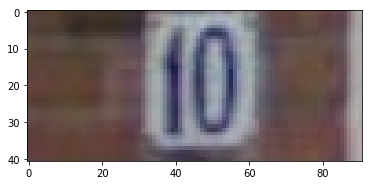

In [5]:
im = np.array(Image.open(TRAIN_PATH + sample['filename']))
plt.imshow(im)

In [6]:
def preprocess(img):
    try:
        img = imresize(img, (224, 224))
        img = img.astype(np.float32) / np.max(np.max(img, axis=1), axis=0)
    except:
        return None
    return img

def gen_cuts(image, boxes):
    cuts = []
    labels = []
    
    number_left = image.shape[1]
    number_right = 0
    number_top = image.shape[0]
    number_bottom = 0
    
    na_w = 0
    na_h = 0
    
    for box in boxes:
        middle = int(box['left'] + box['width'] / 2)
        height = int(box['height'])
        width = height
        left = int(middle - width/2)
        right = left + width
        top = int(box['top'])
        bottom = top + height
        
        if left < number_left: number_left = left
        if right > number_right: number_right = right
        if top < number_top: number_top = top
        if bottom > number_bottom: number_bottom = bottom
        if na_w == 0: na_w = width
        if na_h == 0: na_h = height
        
        cut = im[top:bottom, left:right]
        cut = preprocess(cut)
        
        if cut is None:
            continue
        
        cuts.append(cut)
        label = box['label'] if box['label'] != 10 else 0
        labels.append(int(label))
    
    for left in range(0, image.shape[1]-na_w, na_w):
        if (left+na_w < number_left) or (left > number_right):
            cut = im[0:na_h, left:left+na_w]
            cut = preprocess(cut)

            if cut is None:
                continue
            cuts.append(cut)
            labels.append(10)
    

    return cuts, labels

all_cuts = []
all_labels = []
for i, sample in enumerate(train_ds[:5000]):
    if i % 1000 == 0: print(i)
    im = np.array(Image.open(TRAIN_PATH + sample['filename']))
    img_cuts, img_labels = gen_cuts(im, sample['boxes'])
    all_cuts.extend(img_cuts)
    all_labels.extend(img_labels)

print("{} cuts total".format(len(all_labels)))
print('done!')

0


/home/max/anaconda3/envs/cv_proj/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


1000
2000
3000
4000
14972 cuts total
done!


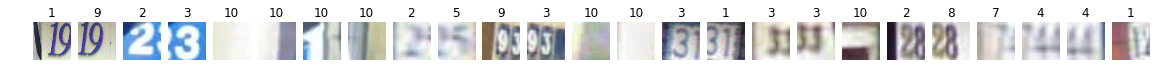

In [7]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=25)

for i, cut in enumerate(all_cuts[:25]):
    ax[i].axis('off')
    ax[i].imshow(cut, cmap='gray')
    ax[i].set_title(all_labels[i], loc='center')

In [8]:
X = np.array(all_cuts)
y = np.array([all_labels]).T
X.shape, y.shape

((14972, 224, 224, 3), (14972, 1))

In [9]:
import time
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.applications.vgg16 import VGG16

# Data

Training data shape :  (11977, 224, 224, 3) (11977, 1)
Testing data shape :  (2995, 224, 224, 3) (2995, 1)
Total number of outputs :  11
Output classes :  [ 0  1  2  3  4  5  6  7  8  9 10]


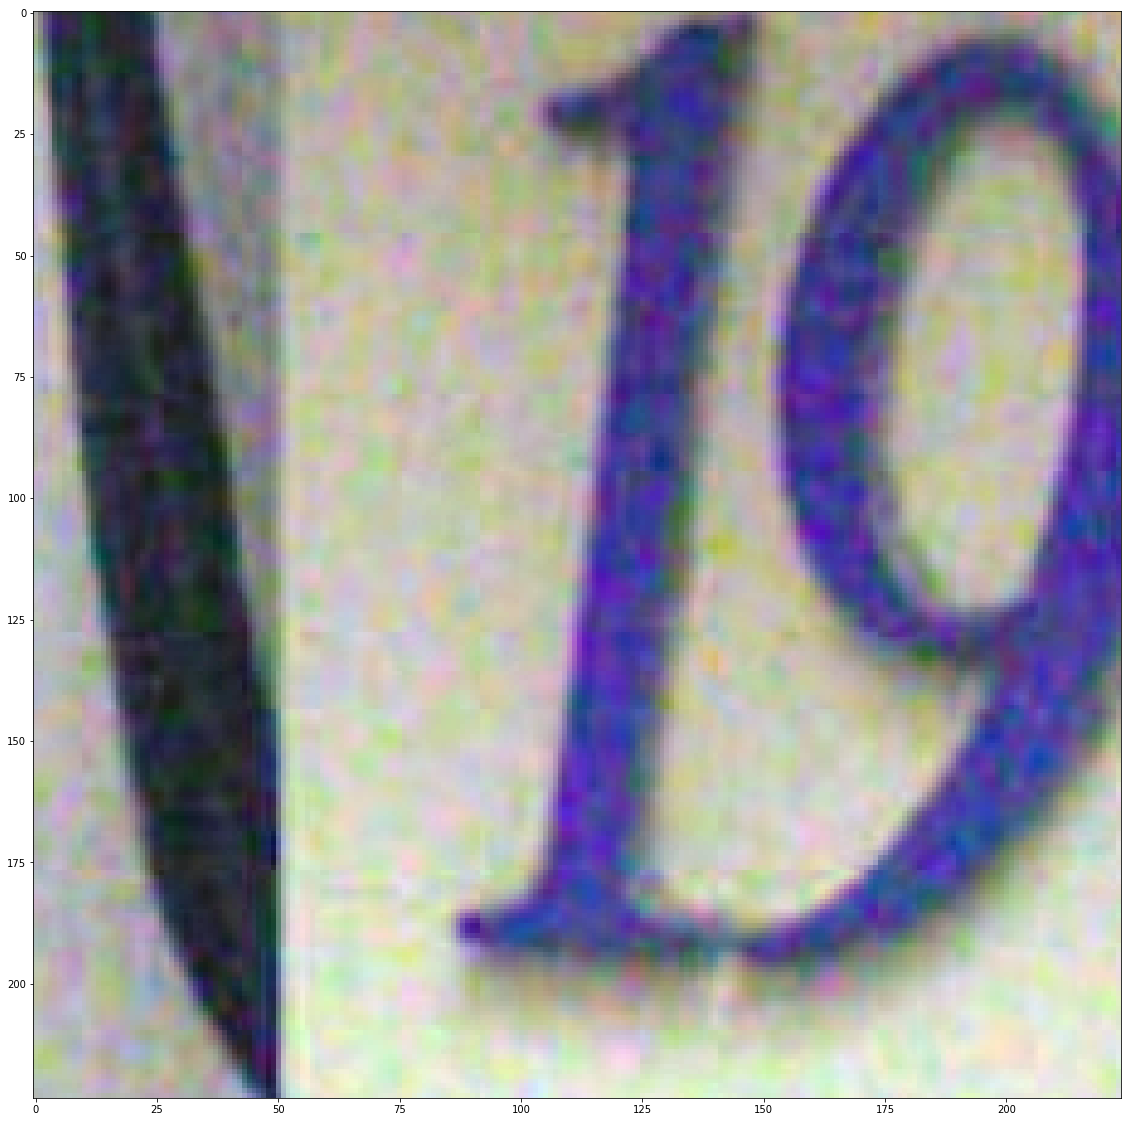

In [10]:
tt_ratio = .8
train_size = int(X.shape[0] * tt_ratio)
train_images, train_labels = X[:train_size], y[:train_size]
test_images, test_labels = X[train_size:], y[train_size:]
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

plt.imshow(train_images[0,:,:])

In [11]:
# shape
nRows,nCols,nDims = train_images.shape[1:]
train_data = train_images.reshape(train_images.shape[0], nRows, nCols, nDims)
test_data = test_images.reshape(test_images.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)
input_shape

(224, 224, 3)

In [12]:
# one-hot encode
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)
train_labels[:5], train_labels_one_hot[:5]

(array([[ 1],
        [ 9],
        [ 2],
        [ 3],
        [10]]), array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32))

# Random weights

## Model

In [13]:
vgg = VGG16(weights=None)
x = Dense(nClasses, activation='softmax')(vgg.layers[-2].output)
model2 = Model(inputs=vgg.input, outputs=x)

batch_size = 32
epochs = 30
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Train

In [14]:
ts = time.time()
history = model2.fit(train_data, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                     validation_data=(test_data, test_labels_one_hot))
model2.evaluate(test_data, test_labels_one_hot)
print(time.time() - ts)

Train on 11977 samples, validate on 2995 samples
Epoch 1/30
11977/11977 [==============================] - 113s 9ms/step - loss: 11.8302 - acc: 0.2645 - val_loss: 11.7482 - val_acc: 0.2711
Epoch 2/30
11977/11977 [==============================] - 107s 9ms/step - loss: 11.8547 - acc: 0.2645 - val_loss: 11.7482 - val_acc: 0.2711
Epoch 3/30
11977/11977 [==============================] - 107s 9ms/step - loss: 11.8547 - acc: 0.2645 - val_loss: 11.7482 - val_acc: 0.2711
Epoch 4/30
11977/11977 [==============================] - 107s 9ms/step - loss: 11.8547 - acc: 0.2645 - val_loss: 11.7482 - val_acc: 0.2711
Epoch 5/30
11977/11977 [==============================] - 107s 9ms/step - loss: 11.8547 - acc: 0.2645 - val_loss: 11.7482 - val_acc: 0.2711
Epoch 6/30
11977/11977 [==============================] - 107s 9ms/step - loss: 11.8547 - acc: 0.2645 - val_loss: 11.7482 - val_acc: 0.2711
Epoch 7/30
11977/11977 [==============================] - 107s 9ms/step - loss: 11.8547 - acc: 0.2645 - val_los

In [15]:
test_labels_pred = model2.predict(test_data).argmax(axis=1)
test_labels_pred

array([10, 10, 10, ..., 10, 10, 10])

## Curves

Text(0.5,1,'Loss Curves')

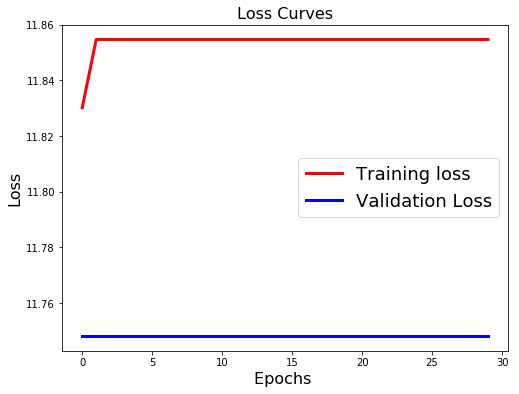

In [16]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

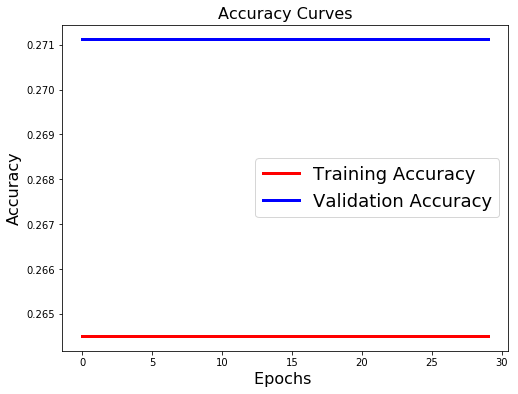

In [17]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Confusion matrix

/home/max/anaconda3/envs/cv_proj/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


Normalized confusion matrix


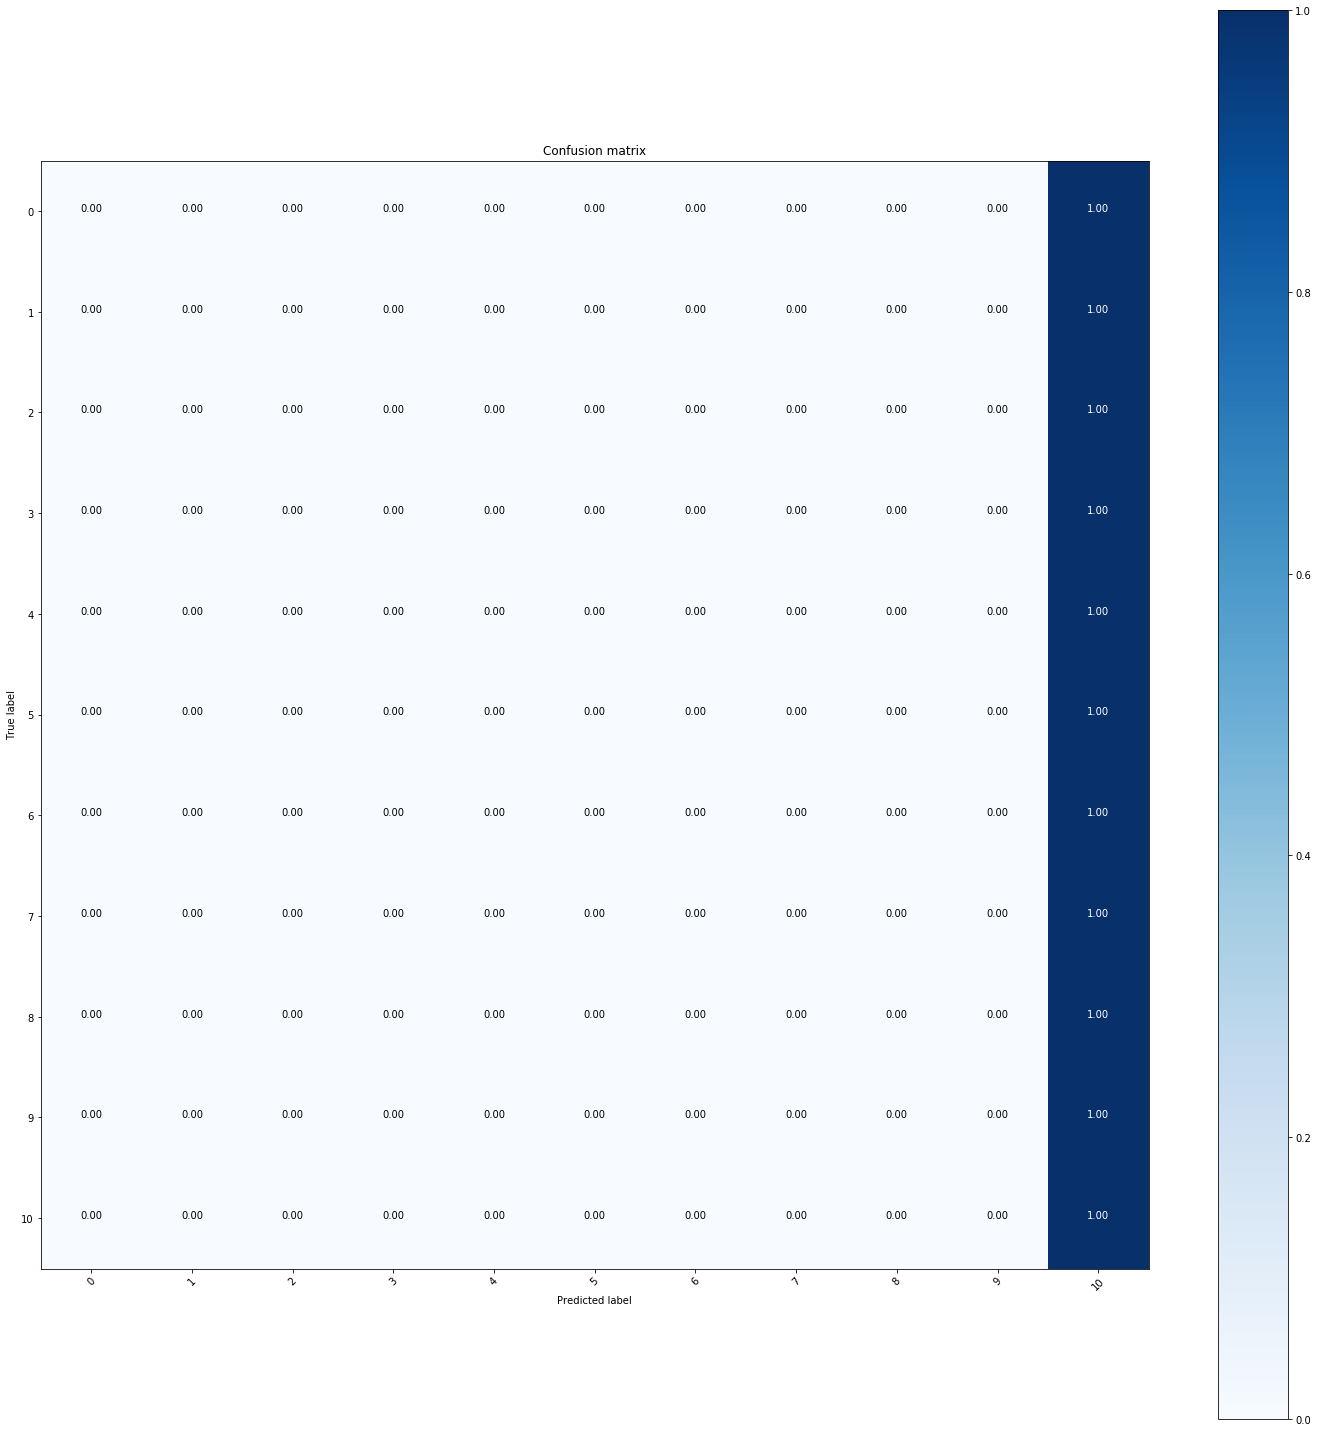

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cm = confusion_matrix(test_labels, test_labels_pred)

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plot_confusion_matrix(cm, classes, normalize=True)

## Save model

In [19]:
model2.save('model2.h5')

# Init weights

## Model

In [20]:
vgg = VGG16(weights='imagenet')
x = Dense(nClasses, activation='softmax')(vgg.layers[-2].output)
model3 = Model(inputs=vgg.input, outputs=x)

batch_size = 32
epochs = 30
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

553467904/553467096 [==============================] - 68s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_p

## Train

In [22]:
ts = time.time()
history = model3.fit(train_data, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                     validation_data=(test_data, test_labels_one_hot))
model3.evaluate(test_data, test_labels_one_hot)
print(time.time() - ts)

Train on 11977 samples, validate on 2995 samples
Epoch 1/30
11977/11977 [==============================] - 105s 9ms/step - loss: 13.8170 - acc: 0.1407 - val_loss: 13.7932 - val_acc: 0.1442
Epoch 2/30
11977/11977 [==============================] - 104s 9ms/step - loss: 13.8451 - acc: 0.1410 - val_loss: 13.7932 - val_acc: 0.1442
Epoch 3/30
11977/11977 [==============================] - 104s 9ms/step - loss: 13.8451 - acc: 0.1410 - val_loss: 13.7932 - val_acc: 0.1442
Epoch 4/30
11977/11977 [==============================] - 104s 9ms/step - loss: 13.8451 - acc: 0.1410 - val_loss: 13.7932 - val_acc: 0.1442
Epoch 5/30
11977/11977 [==============================] - 104s 9ms/step - loss: 13.8451 - acc: 0.1410 - val_loss: 13.7932 - val_acc: 0.1442
Epoch 6/30
11977/11977 [==============================] - 104s 9ms/step - loss: 13.8451 - acc: 0.1410 - val_loss: 13.7932 - val_acc: 0.1442
Epoch 7/30
11977/11977 [==============================] - 104s 9ms/step - loss: 13.8451 - acc: 0.1410 - val_los

In [23]:
test_labels_pred = model3.predict(test_data).argmax(axis=1)
test_labels_pred

array([1, 1, 1, ..., 1, 1, 1])

## Curves

Text(0.5,1,'Loss Curves')

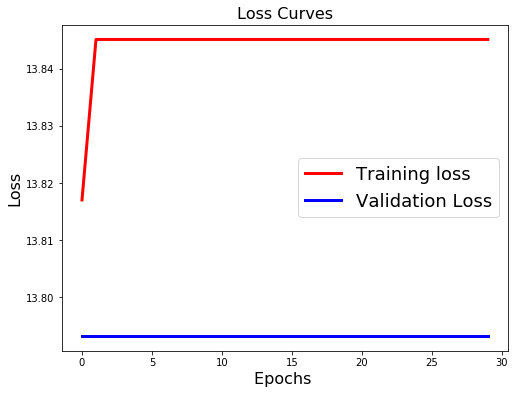

In [24]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

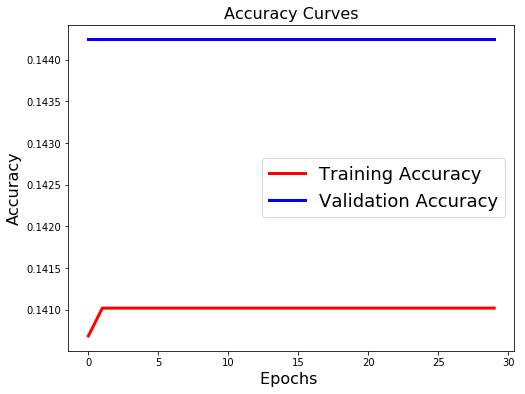

In [25]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Confusion matrix

Normalized confusion matrix


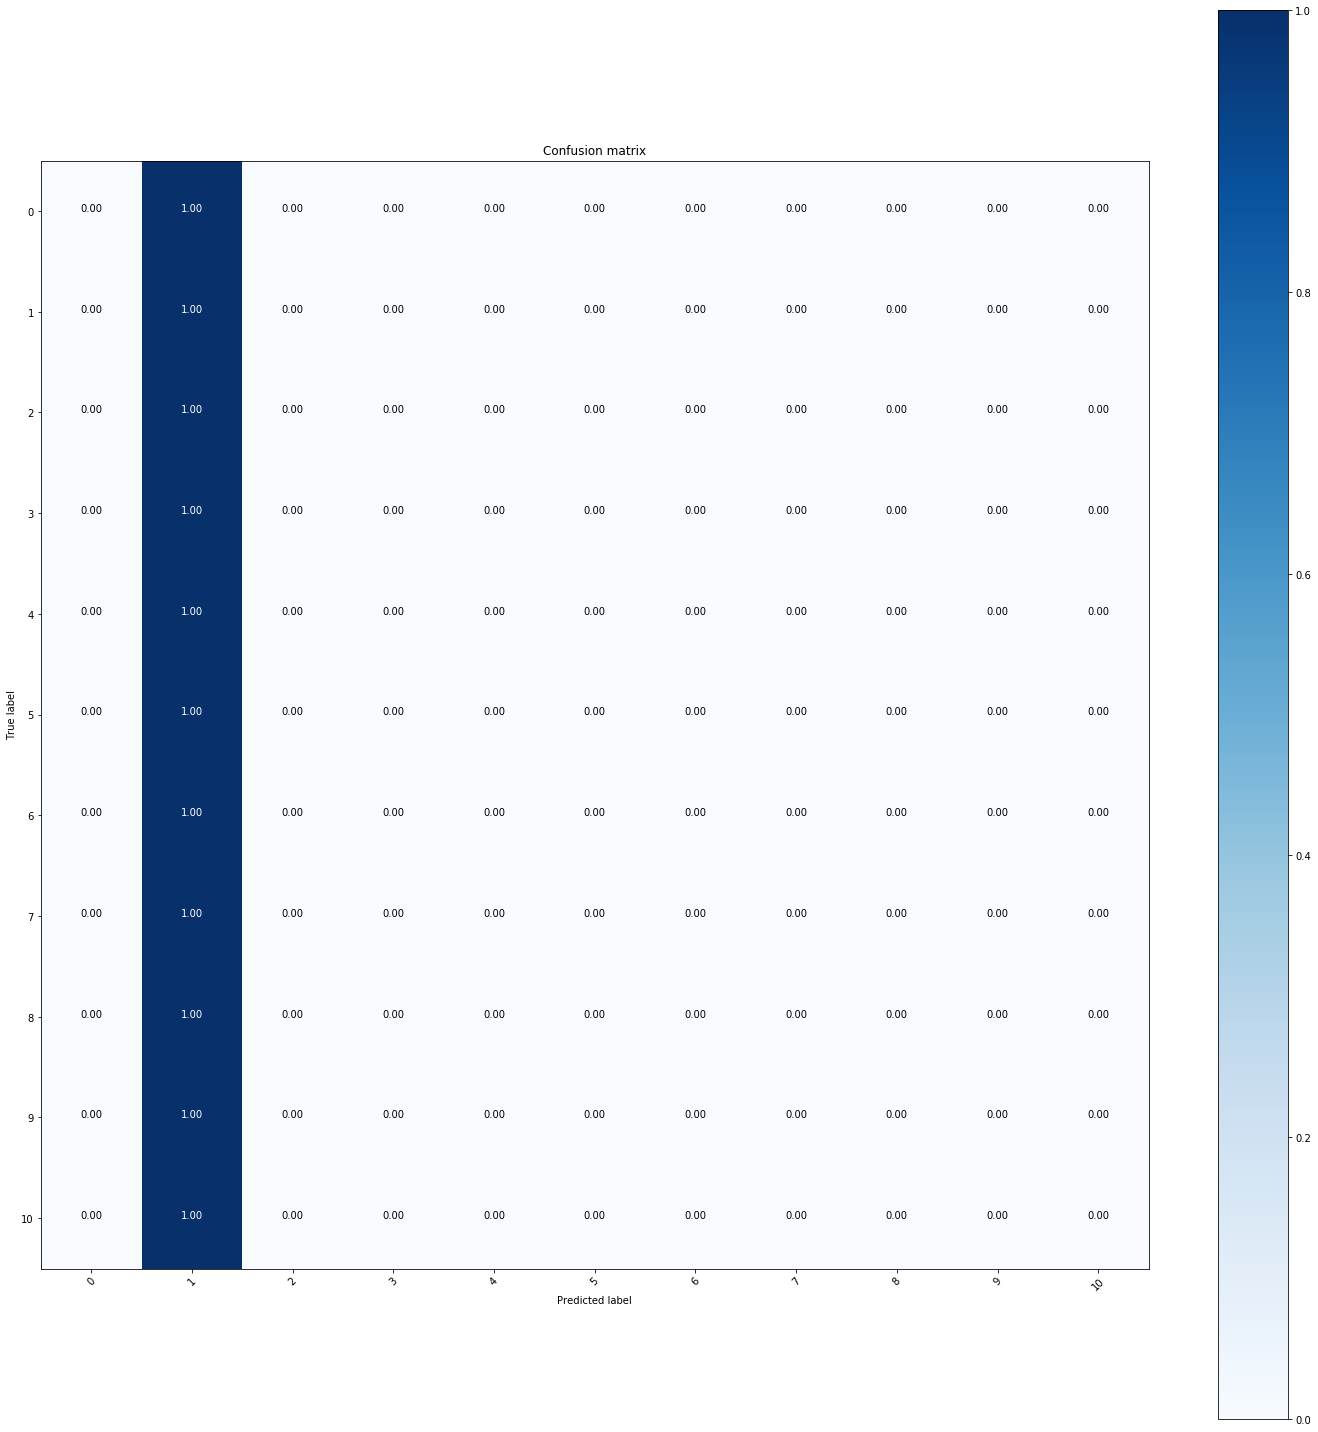

In [26]:
cm = confusion_matrix(test_labels, test_labels_pred)

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plot_confusion_matrix(cm, classes, normalize=True)

## Save model

In [19]:
model3.save('model3.h5')